In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

import layers as layers
import util as util
import networks as networks

In [2]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

In [3]:
def plot_results(x, y, x_plot, model, n_samp=500):
    plt.scatter(x.numpy(), y.numpy())
    f_pred_plot = model(x_plot, sample_input_layer=False, weights_type='mean').detach()
    plt.plot(x_plot.numpy(), f_pred_plot.numpy())
    
    f_samp_plot = torch.zeros(n_samp, x_plot.shape[0])
    for i in range(n_samp):
        f_samp_plot[i,:] = model(x_plot, sample_input_layer=True, weights_type='sample').detach().reshape(-1)

    for q in [.025, .05, .1]:
        ci = np.quantile(f_samp_plot.numpy(), [q, 1-q], axis=0)
        plt.fill_between(x_plot.reshape(-1).numpy(), ci[0,:], ci[1,:], alpha=.1, color='blue')

In [4]:
def plot_results_2d(x, y, x_plot, model, n_samp=500):
    plt.scatter(x[:,0].numpy(), y.numpy())
    f_pred_plot = model(x_plot, sample_input_layer=False, weights_type='mean').detach()
    plt.plot(x_plot[:,0].numpy(), f_pred_plot.numpy())
    
    f_samp_plot = torch.zeros(n_samp, x_plot.shape[0])
    for i in range(n_samp):
        f_samp_plot[i,:] = model(x_plot, sample_input_layer=True, weights_type='sample').detach().reshape(-1)

    for q in [.025, .05, .1]:
        ci = np.quantile(f_samp_plot.numpy(), [q, 1-q], axis=0)
        plt.fill_between(x_plot[:,0].reshape(-1).numpy(), ci[0,:], ci[1,:], alpha=.1, color='blue')

## Basic testing

#### Layer

In [5]:
x = torch.empty((5,1)).normal_(0,1)
y = torch.randn(5,1)

rff layer

In [6]:
l = layers.RffHsLayer(1,6)

In [7]:
l.forward(x, sample=True)

tensor([[ 0.4319,  0.5514,  0.1227,  0.5538,  0.3404, -0.3607],
        [ 0.4073,  0.5573,  0.1200,  0.5553,  0.3545, -0.3663],
        [ 0.4340,  0.5508,  0.1230,  0.5537,  0.3391, -0.3602],
        [ 0.4275,  0.5525,  0.1222,  0.5541,  0.3430, -0.3617],
        [ 0.4099,  0.5567,  0.1203,  0.5551,  0.3531, -0.3657]],
       grad_fn=<MulBackward0>)

In [8]:
l.entropy()

tensor(-20.3013, grad_fn=<AddBackward0>)

In [9]:
l.cross_entropy()

tensor(32.7447, grad_fn=<AddBackward0>)

In [10]:
l.kl_divergence()

tensor(53.0460, grad_fn=<SubBackward0>)

In [11]:
l.fixed_point_updates()

Linear layer

In [12]:

h = torch.randn(5,3)
l = layers.LinearLayer(3)

In [13]:
l.fixed_point_updates(h,y)

In [14]:
l.forward(h, True)

UnboundLocalError: local variable 'w' referenced before assignment

In [ ]:
l.init_parameters()

## Infer prior

In [190]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

Dataset is sample from the prior

In [191]:
model = networks.RffHs(1, 1, dim_hidden=50, sig2_inv=1/.1)

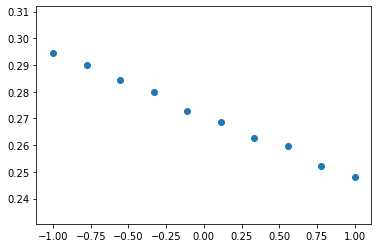

In [197]:
n_obs = 10
sig2 = .001

torch.manual_seed(1)
model.init_parameters()
x = torch.linspace(-1,1, n_obs).reshape(-1,1)
y = model.forward(x, sample=False).detach() + sig2*torch.randn(n_obs).reshape(-1,1)
plt.scatter(x.numpy(), y.numpy())

Epoch[250/1000], kl: 1052.906616, likelihood: 2.262321, elbo: -1050.595215
Epoch[500/1000], kl: 1044.439209, likelihood: 0.835122, elbo: -1042.244873
Epoch[750/1000], kl: 1036.899292, likelihood: 1.461719, elbo: -1036.358887
Epoch[1000/1000], kl: 1030.976562, likelihood: 0.789685, elbo: -1030.020142


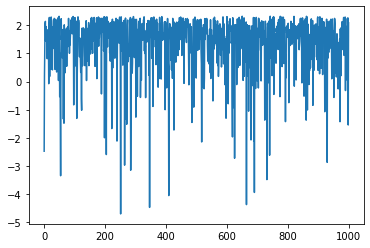

In [178]:
optimizer = torch.optim.Adam(model.parameters(), lr=.001)
#model.reinit_parameters(x,y,n_reinit=10) # comment out to start at truth
elbo = -networks.train(model, optimizer, x, y, n_epochs=1000, print_freq=250)
plt.plot(elbo)

In [198]:
torch.exp(model.layer_in.lognu_mu + model.layer_in.lognu_logsig2.exp()/2)

tensor([0.2478], grad_fn=<ExpBackward>)

In [199]:
torch.exp(model.layer_in.logeta_mu + model.layer_in.logeta_logsig2.exp()/2)

tensor([0.1375], grad_fn=<ExpBackward>)

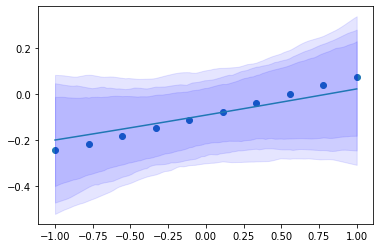

In [180]:
x_plot = torch.linspace(-1,1,100).reshape(-1,1)
plot_results(x,y,x_plot, model)

In [133]:
for name, p in model.named_parameters():
    print(name)

layer_in.lognu_mu
layer_in.lognu_logsig2
layer_in.logeta_mu
layer_in.logeta_logsig2


## Very simple

In [170]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

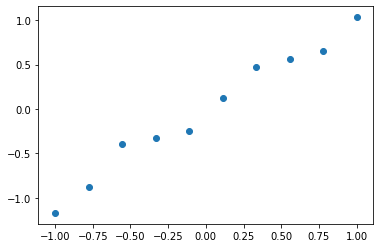

In [171]:
n_obs = 10
sig2 = .1
x = torch.linspace(-1,1,n_obs).reshape(-1,1)
y = x + sig2*torch.randn(n_obs).reshape(-1,1)
plt.scatter(x.numpy(), y.numpy()) 

In [172]:
torch.manual_seed(2)
model = networks.RffHs(1, 1, dim_hidden=50, sig2_inv=1/sig2)

before: 53.12535095214844
temp:  0.0
after: 49.41743087768555
Epoch[1/20], kl: 9.870914, likelihood: 0.905743, elbo: -8.969007
before: 8.969561576843262
temp:  0.1
after: 8.88606071472168
Epoch[2/20], kl: 9.813745, likelihood: -1.406684, elbo: -11.193604
before: 11.190902709960938
temp:  0.2
after: 11.076574325561523
Epoch[3/20], kl: 9.693310, likelihood: -4.289975, elbo: -13.893942
before: 13.523109436035156
temp:  0.3
after: 9.888239860534668
Epoch[4/20], kl: 9.587626, likelihood: -0.517507, elbo: -10.289548
before: 10.180636405944824
temp:  0.4
after: 9.839422225952148
Epoch[5/20], kl: 9.473281, likelihood: 1.318923, elbo: -8.191963
before: 8.208085060119629
temp:  0.5
after: 7.974469184875488
Epoch[6/20], kl: 9.351330, likelihood: -0.869817, elbo: -10.190041
before: 10.234725952148438
temp:  0.6
after: 9.745489120483398
Epoch[7/20], kl: 9.226768, likelihood: -3.648032, elbo: -12.937802
before: 12.962788581848145
temp:  0.7
after: 12.813364028930664
Epoch[8/20], kl: 9.110188, likeli

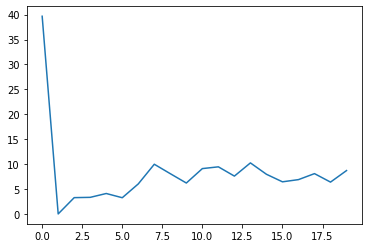

In [173]:
torch.manual_seed(2)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
model.reinit_parameters(x,y,n_reinit=10) 
elbo = -networks.train(model, optimizer, x, y, n_epochs=20, n_rep_opt=1000, print_freq=1)
plt.plot(-elbo)

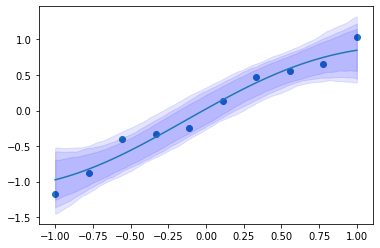

In [174]:
x_plot = torch.linspace(-1,1,100).reshape(-1,1)
plot_results(x,y,x_plot, model)

In [156]:
model.loss(x, y, x_linear=None, temperature=1)

tensor(-1.0373, grad_fn=<AddBackward0>)

In [175]:
for name, p in model.named_parameters():
    print(name, p.detach().item())

layer_in.lognu_mu -0.3546416163444519
layer_in.lognu_logsig2 -7.0078606605529785
layer_in.logeta_mu 0.264578640460968
layer_in.logeta_logsig2 -7.000840663909912


In [158]:
model.layer_in.vtheta_b

tensor([2.4350])

In [159]:
model.layer_in.psi_b

tensor([1.7287])

## Checking KL

In [128]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

In [129]:
torch.manual_seed(2)
model = networks.RffHs(1, 1, dim_hidden=50, sig2_inv=1/sig2)

entropy: lognormal

In [130]:
# My code
self = model.layer_in
util.lognormal_entropy(self.lognu_logsig2.exp().sqrt().log(), self.lognu_mu, 1)


tensor(-2.5203, grad_fn=<AddBackward0>)

In [131]:
# Torch 
m = torch.distributions.log_normal.LogNormal(self.lognu_mu, \
                                             self.lognu_logsig2.exp().sqrt())
m.entropy()

tensor([-2.5203], grad_fn=<AddBackward0>)

entropy: invgamma

In [132]:
# My code
util.entropy_invgamma(self.vtheta_a, self.vtheta_b)


tensor(2.6055, grad_fn=<SumBackward0>)

In [133]:
# Scipy
from scipy.stats import invgamma
ig = invgamma(a=self.vtheta_a.item(), scale=self.vtheta_b.item())
ig.entropy()

array(2.60545596)

## Very simple 2D

In [203]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

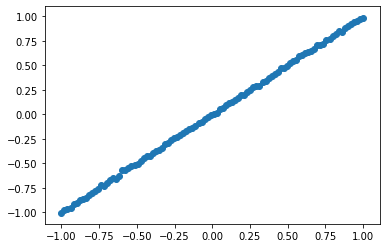

In [204]:
n_obs = 100
sig2 = .01
x1 = torch.linspace(-1,1,n_obs).reshape(-1,1)
y = x1 + sig2*torch.randn(n_obs).reshape(-1,1)

x2 = torch.randn(n_obs).reshape(-1,1)
x = torch.cat([x1,x2],dim=1)
plt.scatter(x1.numpy(), y.numpy()) 

In [205]:
torch.manual_seed(2)
model = networks.RffHs(2, 1, dim_hidden=50, sig2_inv=1/sig2)

before: 14453.8662109375
temp:  0.0
after: 14454.630859375
Using np.random.multivariate_normal
Epoch[1/1], kl: 19.028212, likelihood: -330231.625000, elbo: -328937.406250


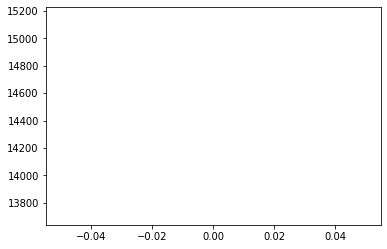

In [206]:
torch.manual_seed(2)
optimizer = torch.optim.Adam(model.parameters(), lr=.0001)
model.reinit_parameters(x,y,n_reinit=10) 
elbo = -networks.train(model, optimizer, x, y, n_epochs=1, n_rep_opt=100, print_freq=1)
plt.plot(-elbo)

Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate

Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate

Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal
Using np.random.multivariate_normal


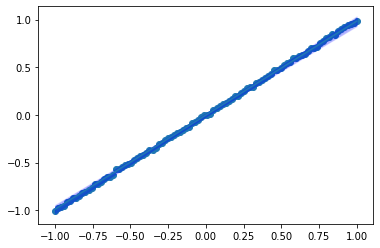

In [207]:
x_plot = torch.linspace(-1,1,100).reshape(-1,1)
x_plot = torch.cat([x_plot, torch.zeros(x_plot.shape[0]).reshape(-1,1)],dim=1)
plot_results_2d(x,y,x_plot, model)

## Simple model

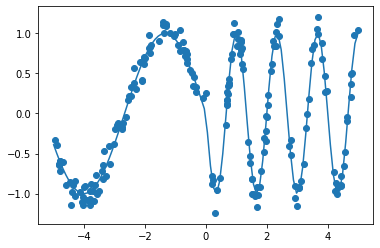

In [35]:
# Toy data
x_true = torch.tensor(np.linspace(-5,5,100).reshape(-1,1), dtype=torch.float)
x, x_val, y, y_val, y_scale, y_true = util.gen_toy_data(num_train=200, x_true=x_true)

plt.scatter(x.numpy(), y.numpy())
plt.plot(x_true.numpy(), y_true.numpy())

In [36]:
importlib.reload(layers)
importlib.reload(util)
importlib.reload(networks)

<module 'networks' from '/Users/beaucoker/Documents/git/VS-BNN/code/horseshoe/networks.py'>

In [16]:
model = networks.RffHs(x.shape[1],y.shape[1], dim_hidden=300, sig2_inv=1/.1)
optimizer = torch.optim.Adam(model.parameters(), lr=.001)

In [17]:
model.reinit_parameters(x,y,n_reinit=10)

In [18]:
elbo = -networks.train(model, optimizer, x, y, n_epochs=1, print_freq=1000)


In [19]:
#plt.plot(elbo.numpy())

//anaconda/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


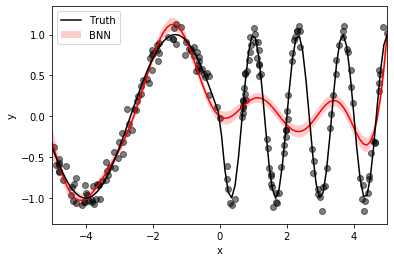

In [20]:
def plot_varbnn(bnn, n_samp, x_true):
    #bnn = networks.RffHs(x.shape[1],y.shape[1], dim_hidden=100, sig2_inv=1/.1)
    y_samps=np.array([bnn(x_true, sample=True).view(-1).detach().numpy() for _ in range(n_samp)])
    sns.tsplot(y_samps, time=x_true.numpy(),ci='sd',color='red')
    plt.scatter(x.numpy(),y.numpy(), color='k', alpha=.5)
    plt.plot(x_true.numpy(),y_true.numpy(), color='k')
    plt.legend(['Truth','BNN'])

    plt.xlabel('x')
    plt.ylabel('y')  
    
    
plot_varbnn(model, 100, x_true)



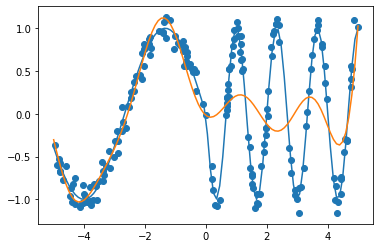

In [21]:
plt.scatter(x.numpy(), y.numpy())
plt.plot(x_true.numpy(), y_true.numpy())
plt.plot(x_true.numpy(), model.forward(x_true, sample=False).detach().numpy())

In [241]:
for name, param in model.named_parameters():
    print(name, param.data)

layer_in.lognu_mu tensor([-3.2843])
layer_in.lognu_logsig2 tensor([-9.0196])
layer_in.logeta_mu tensor([-2.8806, -2.5622, -1.1230, -5.2147, -1.6749, -2.4959, -2.1409, -2.0977,
        -2.4344, -2.2622, -1.1728, -2.4860, -7.2789, -3.3983, -3.0443, -2.1481,
        -4.5675, -0.8988,  0.6402, -1.9453,  0.3479, -2.4036, -1.5921, -1.3321,
        -4.0842, -2.9167, -3.0227, -3.8060, -2.3711, -2.1440, -1.5033, -0.7538,
        -2.4705, -1.3816, -2.8476, -3.0089, -1.7845, -1.3732, -2.9796, -0.9387,
        -2.5895, -2.0773, -1.3593, -5.6289, -0.6216, -1.5813, -3.1768, -1.8976,
        -1.5697, -0.6090,  0.1575, -1.2094, -3.3152, -3.7155, -2.5268, -2.1353,
        -2.8509, -2.0690, -1.5794, -1.7594, -2.5039, -1.4314, -3.5786, -1.6298,
        -2.2987, -2.3906, -1.7098, -2.7475, -3.7468, -1.1912, -2.9848, -2.1111,
        -1.6484, -2.1595, -2.6261, -4.0142, -0.6266, -3.5723, -3.9156, -0.3017,
        -7.4117, -1.3329, -1.8659, -3.9640,  2.1289, -2.6164, -2.1809, -0.7022,
        -2.9029,  1.1924